In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import mplfinance as mpf
import asyncio
import plotly.express as px
from pathlib import Path
import time as t
import threading
import requests
from requests import Request, Session
import datetime
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json

%matplotlib inline

In [12]:
from dotenv import load_dotenv
load_dotenv()

True

***_INDEX TOKENS_***

In [13]:
# Request data from Kuc API & Convert to Json
btc = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=BTC-USDT&startAt=1620360000&endAt=0')
btc_j = btc.json()

# Convert json to DataFrame
btc_df = pd.DataFrame(btc_j['data'])

# Rename Date, Open, & Close columns and remove others
btc_df.rename(columns={0:'Date',1:'Open',2:'Close'}, inplace=True)

btc_df.drop(columns = [3,4,5,6], inplace=True)

# Create A DF with Median Price 

btc_median = btc_df[['Open','Close']].astype(float)

btc_median['BTC Median'] = btc_median[['Open','Close']].mean(axis=1)
btc_median = btc_median['BTC Median']

btc_df_date = pd.to_datetime(btc_df['Date'], unit='s')
btc_date = [btc_df_date, btc_median]
btc_result = pd.concat(btc_date, axis=1, join = 'outer')
#btc__fin = pd.DataFrame(btc_result)
btc_plot = btc_result.set_index('Date')
btc_result.set_index('Date', inplace=True)

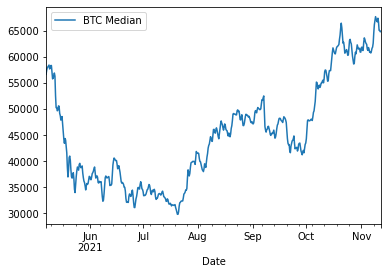

In [25]:
btc_plot.plot();

In [5]:
eth = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=ETH-USDT&startAt=1620360000&endAt=0')
eth_j = eth.json()
eth_df = pd.DataFrame(eth_j['data'])
eth_df.rename(columns={0:'Date',1:'Open',2:'Close'}, inplace=True)
eth_df.drop(columns = [3,4,5,6], inplace=True)
eth_median = eth_df[['Open','Close']].astype(float)
eth_median['ETH Median'] = eth_median[['Open','Close']].mean(axis=1)
eth_median = eth_median['ETH Median']
eth_df_date = pd.to_datetime(eth_df['Date'], unit='s')
eth_date = [eth_df_date, eth_median]
eth_result = pd.concat(eth_date, axis=1, join = 'outer')
eth_result.set_index('Date', inplace=True)
eth_result

,ETH Median
Date,
2021-11-12 00:00:00,4725.105
2021-11-11 16:00:00,4719.540
2021-11-11 08:00:00,4705.560
2021-11-11 00:00:00,4661.345
2021-11-10 16:00:00,4739.455
...,...
2021-05-08 16:00:00,3770.255
2021-05-08 08:00:00,3579.080
2021-05-08 00:00:00,3503.850


In [6]:
bnb = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=BNB-USDT&startAt=1620360000&endAt=0')
bnb_j = bnb.json()
bnb_df = pd.DataFrame(bnb_j['data'])
bnb_df.rename(columns={0:'Date',1:'Open',2:'Close'}, inplace=True)
bnb_df.drop(columns = [3,4,5,6], inplace=True)
bnb_median = bnb_df[['Open','Close']].astype(float)
bnb_median['BNB Median'] = bnb_median[['Open','Close']].mean(axis=1)
bnb_median = bnb_median['BNB Median']
bnb_df_date = pd.to_datetime(bnb_df['Date'], unit='s')
bnb_date = [bnb_df_date, bnb_median]
bnb_result = pd.concat(bnb_date, axis=1, join = 'outer')
bnb_result.set_index('Date', inplace=True)

In [7]:
doge = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=DOGE-USDT&startAt=1620360000&endAt=0')
doge_j = doge.json()
doge_df = pd.DataFrame(doge_j['data'])
doge_df.rename(columns={0:'Date',1:'Open',2:'Close'}, inplace=True)
doge_df.drop(columns = [3,4,5,6], inplace=True)
doge_median = doge_df[['Open','Close']].astype(float)
doge_median['DOGE Median'] = doge_median[['Open','Close']].mean(axis=1)
doge_median = doge_median['DOGE Median']
doge_df_date = pd.to_datetime(doge_df['Date'], unit='s')
doge_date = [doge_df_date, doge_median]
doge_result = pd.concat(doge_date, axis=1, join = 'outer')
doge_result.set_index('Date', inplace=True)

In [8]:
ltc = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=LTC-USDT&startAt=1620360000&endAt=0')
ltc_j = ltc.json()
ltc_df = pd.DataFrame(ltc_j['data'])
ltc_df.rename(columns={0:'Date',1:'Open',2:'Close'}, inplace=True)
ltc_df.drop(columns = [3,4,5,6], inplace=True)
ltc_median = ltc_df[['Open','Close']].astype(float)
ltc_median['LTC Median'] = ltc_median[['Open','Close']].mean(axis=1)
ltc_median = ltc_median['LTC Median']
ltc_df_date = pd.to_datetime(ltc_df['Date'], unit='s')
ltc_date = [ltc_df_date, ltc_median]
ltc_result = pd.concat(ltc_date, axis=1, join = 'outer')
ltc_result.set_index('Date', inplace=True)

In [15]:
ada = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=ADA-USDT&startAt=1620360000&endAt=0')
ada_j = ada.json()
ada_df = pd.DataFrame(ada_j['data'])
ada_df.rename(columns={0:'Date',1:'Open',2:'Close'}, inplace=True)
ada_df.drop(columns = [3,4,5,6], inplace=True)
ada_median = ada_df[['Open','Close']].astype(float)
ada_median['ADA Median'] = ada_median[['Open','Close']].mean(axis=1)
ada_median = ada_median['ADA Median']
ada_df_date = pd.to_datetime(ada_df['Date'], unit='s')
ada_date = [ada_df_date, ada_median]
ada_result = pd.concat(ada_date, axis=1, join = 'outer')
ada_result.set_index('Date', inplace=True)

In [16]:
xrp = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=XRP-USDT&startAt=1620360000&endAt=0')
xrp_j = xrp.json()
xrp_df = pd.DataFrame(xrp_j['data'])
xrp_df.rename(columns={0:'Date',1:'Open',2:'Close'}, inplace=True)
xrp_df.drop(columns = [3,4,5,6], inplace=True)
xrp_median = xrp_df[['Open','Close']].astype(float)
xrp_median['XRP Median'] = xrp_median[['Open','Close']].mean(axis=1)
xrp_median = xrp_median['XRP Median']
xrp_df_date = pd.to_datetime(xrp_df['Date'], unit='s')
xrp_date = [xrp_df_date, xrp_median]
xrp_result = pd.concat(xrp_date, axis=1, join = 'outer')
xrp_result.set_index('Date', inplace=True)

In [17]:
usdt = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=USDT-USDC&startAt=1620360000&endAt=0')
usdt_j = usdt.json()
usdt_df = pd.DataFrame(usdt_j['data'])
usdt_df.rename(columns={0:'Date',1:'Open',2:'Close'}, inplace=True)
usdt_df.drop(columns = [3,4,5,6], inplace=True)
usdt_median = usdt_df[['Open','Close']].astype(float)
usdt_median['USDT Median'] = usdt_median[['Open','Close']].mean(axis=1)
usdt_median = usdt_median['USDT Median']
usdt_df_date = pd.to_datetime(usdt_df['Date'], unit='s')
usdt_date = [usdt_df_date, usdt_median]
usdt_result = pd.concat(usdt_date, axis=1, join = 'outer')
usdt_result.set_index('Date', inplace=True)

In [18]:
link = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=LINK-USDT&startAt=1620360000&endAt=0')
link_j = link.json()
link_df = pd.DataFrame(link_j['data'])
link_df.rename(columns={0:'Date',1:'Open',2:'Close'}, inplace=True)
link_df.drop(columns = [3,4,5,6], inplace=True)
link_median = link_df[['Open','Close']].astype(float)
link_median['LINK Median'] = link_median[['Open','Close']].mean(axis=1)
link_median = link_median['LINK Median']
link_df_date = pd.to_datetime(link_df['Date'], unit='s')
link_date = [link_df_date, link_median]
link_result = pd.concat(link_date, axis=1, join = 'outer')
link_result.set_index('Date', inplace=True)

In [22]:
uni = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=UNI-USDT&startAt=1620360000&endAt=0')
uni_j = uni.json()
uni_df = pd.DataFrame(uni_j['data'])
uni_df.rename(columns={0:'Date',1:'Open',2:'Close'}, inplace=True)
uni_df.drop(columns = [3,4,5,6], inplace=True)
uni_median = uni_df[['Open','Close']].astype(float)
uni_median['UNI Median'] = uni_median[['Open','Close']].mean(axis=1)
uni_median = uni_median['UNI Median']
uni_df_date = pd.to_datetime(uni_df['Date'], unit='s')
uni_date = [uni_df_date, uni_median]
uni_result = pd.concat(uni_date, axis=1, join = 'outer')
uni_result.set_index('Date', inplace=True)
uni_result

,UNI Median
Date,
2021-11-12 00:00:00,25.40110
2021-11-11 16:00:00,25.41365
2021-11-11 08:00:00,25.59940
2021-11-11 00:00:00,25.49950
2021-11-10 16:00:00,26.59735
...,...
2021-05-08 16:00:00,40.26905
2021-05-08 08:00:00,39.83970
2021-05-08 00:00:00,39.68295


In [24]:
dot = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=DOT-USDT&startAt=1620360000&endAt=0')
dot_j = dot.json()
dot_df = pd.DataFrame(dot_j['data'])
dot_df.rename(columns={0:'Date',1:'Open',2:'Close'}, inplace=True)
dot_df.drop(columns = [3,4,5,6], inplace=True)
dot_median = dot_df[['Open','Close']].astype(float)
dot_median['DOT Median'] = dot_median[['Open','Close']].mean(axis=1)
dot_median = dot_median['DOT Median']
dot_df_date = pd.to_datetime(dot_df['Date'], unit='s')
dot_date = [dot_df_date, dot_median]
dot_result = pd.concat(dot_date, axis=1, join = 'outer')
dot_result.set_index('Date', inplace=True)
dot_result

,DOT Median
Date,
2021-11-12 00:00:00,47.53695
2021-11-11 16:00:00,47.64415
2021-11-11 08:00:00,48.48280
2021-11-11 00:00:00,47.96535
2021-11-10 16:00:00,49.00785
...,...
2021-05-08 16:00:00,39.39945
2021-05-08 08:00:00,39.51780
2021-05-08 00:00:00,40.01940


In [27]:
index_tokens = pd.concat([btc_result, eth_result, ada_result, doge_result, ltc_result, bnb_result, xrp_result, uni_result, link_result, usdt_result], axis=1, join='outer')
index_tokens

,BTC Median,ETH Median,ADA Median,DOGE Median,LTC Median,BNB Median,XRP Median,UNI Median,LINK Median,USDT Median
Date,,,,,,,,,,
2021-11-12 00:00:00,64849.60,4725.105,2.085035,0.261340,266.1945,630.7725,1.222020,25.40110,34.96985,1.00065
2021-11-11 16:00:00,64787.50,4719.540,2.079219,0.263155,263.5515,626.6740,1.213485,25.41365,35.06160,1.00040
2021-11-11 08:00:00,65023.70,4705.560,2.109834,0.263585,265.0075,627.6265,1.228695,25.59940,35.84615,1.00035
2021-11-11 00:00:00,65066.80,4661.345,2.120424,0.258475,262.8735,622.4050,1.217850,25.49950,35.22165,1.00065
2021-11-10 16:00:00,66616.00,4739.455,2.175009,0.263620,273.7815,632.7695,1.256170,26.59735,36.17580,1.00040
...,...,...,...,...,...,...,...,...,...,...
2021-05-08 16:00:00,58229.95,3770.255,1.594860,0.644480,341.1250,643.0210,1.554750,40.26905,47.78225,1.00160
2021-05-08 08:00:00,58026.20,3579.080,1.603436,0.679830,340.6505,634.3460,1.573590,39.83970,47.80075,1.00140
2021-05-08 00:00:00,57881.45,3503.850,1.646801,0.698930,345.5525,626.4420,1.589135,39.68295,48.89850,1.00120


***_MEME/GAMING TOKENS_***

In [ ]:
doge = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=DOGE-USDT&startAt=1620360000&endAt=0')
doge_j = doge.json()
doge_j

In [ ]:
elon = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=ELON-USDT&startAt=1620360000&endAt=0')
elon_j = elon.json()
elon_j

***_DEFI TOKENS_***

In [ ]:
uni = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=UNI-USDT&startAt=1620360000&endAt=0')
uni_j = uni.json()
uni_j

In [ ]:
luna = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=LUNA-USDT&startAt=1620360000&endAt=0')
luna_j = luna.json()
luna_j

In [ ]:
avax = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=AVAX-USDT&startAt=1620360000&endAt=0')
avax_j = avax.json()
avax_j

***_STORAGE TOKENS_***

In [ ]:
fil = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=FIL-USDT&startAt=1620360000')
fil_j = fil.json()
fil_j

In [ ]:
btt = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=BTT-USDT&startAt=1620360000')
btt_j = btt.json()
btt_j

In [ ]:
storj = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=STORJ-USDT&startAt=1620360000')
storj_j = storj.json()
storj_j